In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy import units as u
import astropy 

import loadSP as lsp
import cosmo
import halos

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
# ##########################################################
# Format tick labels using their exponent only... 
# ##########################################################
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [4]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.2669999897, Ob0=0.0445, name='myCosmo')
# Make sure we have halo information for this z... hop/...
z = 12.0
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
boxsizecm = lsp.getBoxSize(num,"/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/")
print("boxsize from info {:.2f} at z={}".format((boxsizecm * u.cm).to(u.kpc),z))

print("Using astropy cosmology: size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))


IOError: [Errno 2] No such file or directory: '/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/output_00043/info_00043.txt'

In [5]:
sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))

Boxsize from kKey file = 324.44 kpc


In [11]:
locs, mass, bt, Z, PZ, PPF = lsp.loadSP(z)

In [12]:
baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
spAges = baseAge - bt/1e6
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))

min sp age 0.30 Myr
max sp age 179.21 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.13e-01 Solar


In [13]:
# import importlib
# importlib.reload(lsp)
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num) # Returns positions normalized to (-0.5, 0.5)
halosRawPos = halosRawPos[0:300]
#tbox = boxsizecm/lsp.cmInPc/1000.0 # Convert cm to kpc
tbox = sizeKeys[sizeKeys[::,0] == z][0,1]     # This works too.. 
# tbox = (3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc) # Last resort!
print("boxsize at z={:.2f} is {:.2f}".format(z,tbox))
halosPos = halosRawPos * tbox
len(halosRawPos)

boxsize at z=12.00 is 324.44


300

# Generate the magnitudes... 

In [14]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
astroPyCosmo = FlatLambdaCDM(H0=71.0, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [15]:
arcPerKpc = astroPyCosmo.arcsec_per_kpc_comoving(z=9.5)
print('Comoving:',arcPerKpc)
arcPerKpc = astroPyCosmo.arcsec_per_kpc_proper(z=9.5)
print('Proper:',arcPerKpc)


('Comoving:', <Quantity 0.020734679928940715 arcsec / kpc>)
('Proper:', <Quantity 0.21771413925387748 arcsec / kpc>)


In [16]:
kpcPerArcSec = cosmo.arcAtz(71,z=9.5,om=0.24, ol=1.0-0.24) # size of an arcsec at the specified reshift in kpc
print('Proper:',1.0 / kpcPerArcSec)


('Proper:', 0.21744697332907817)


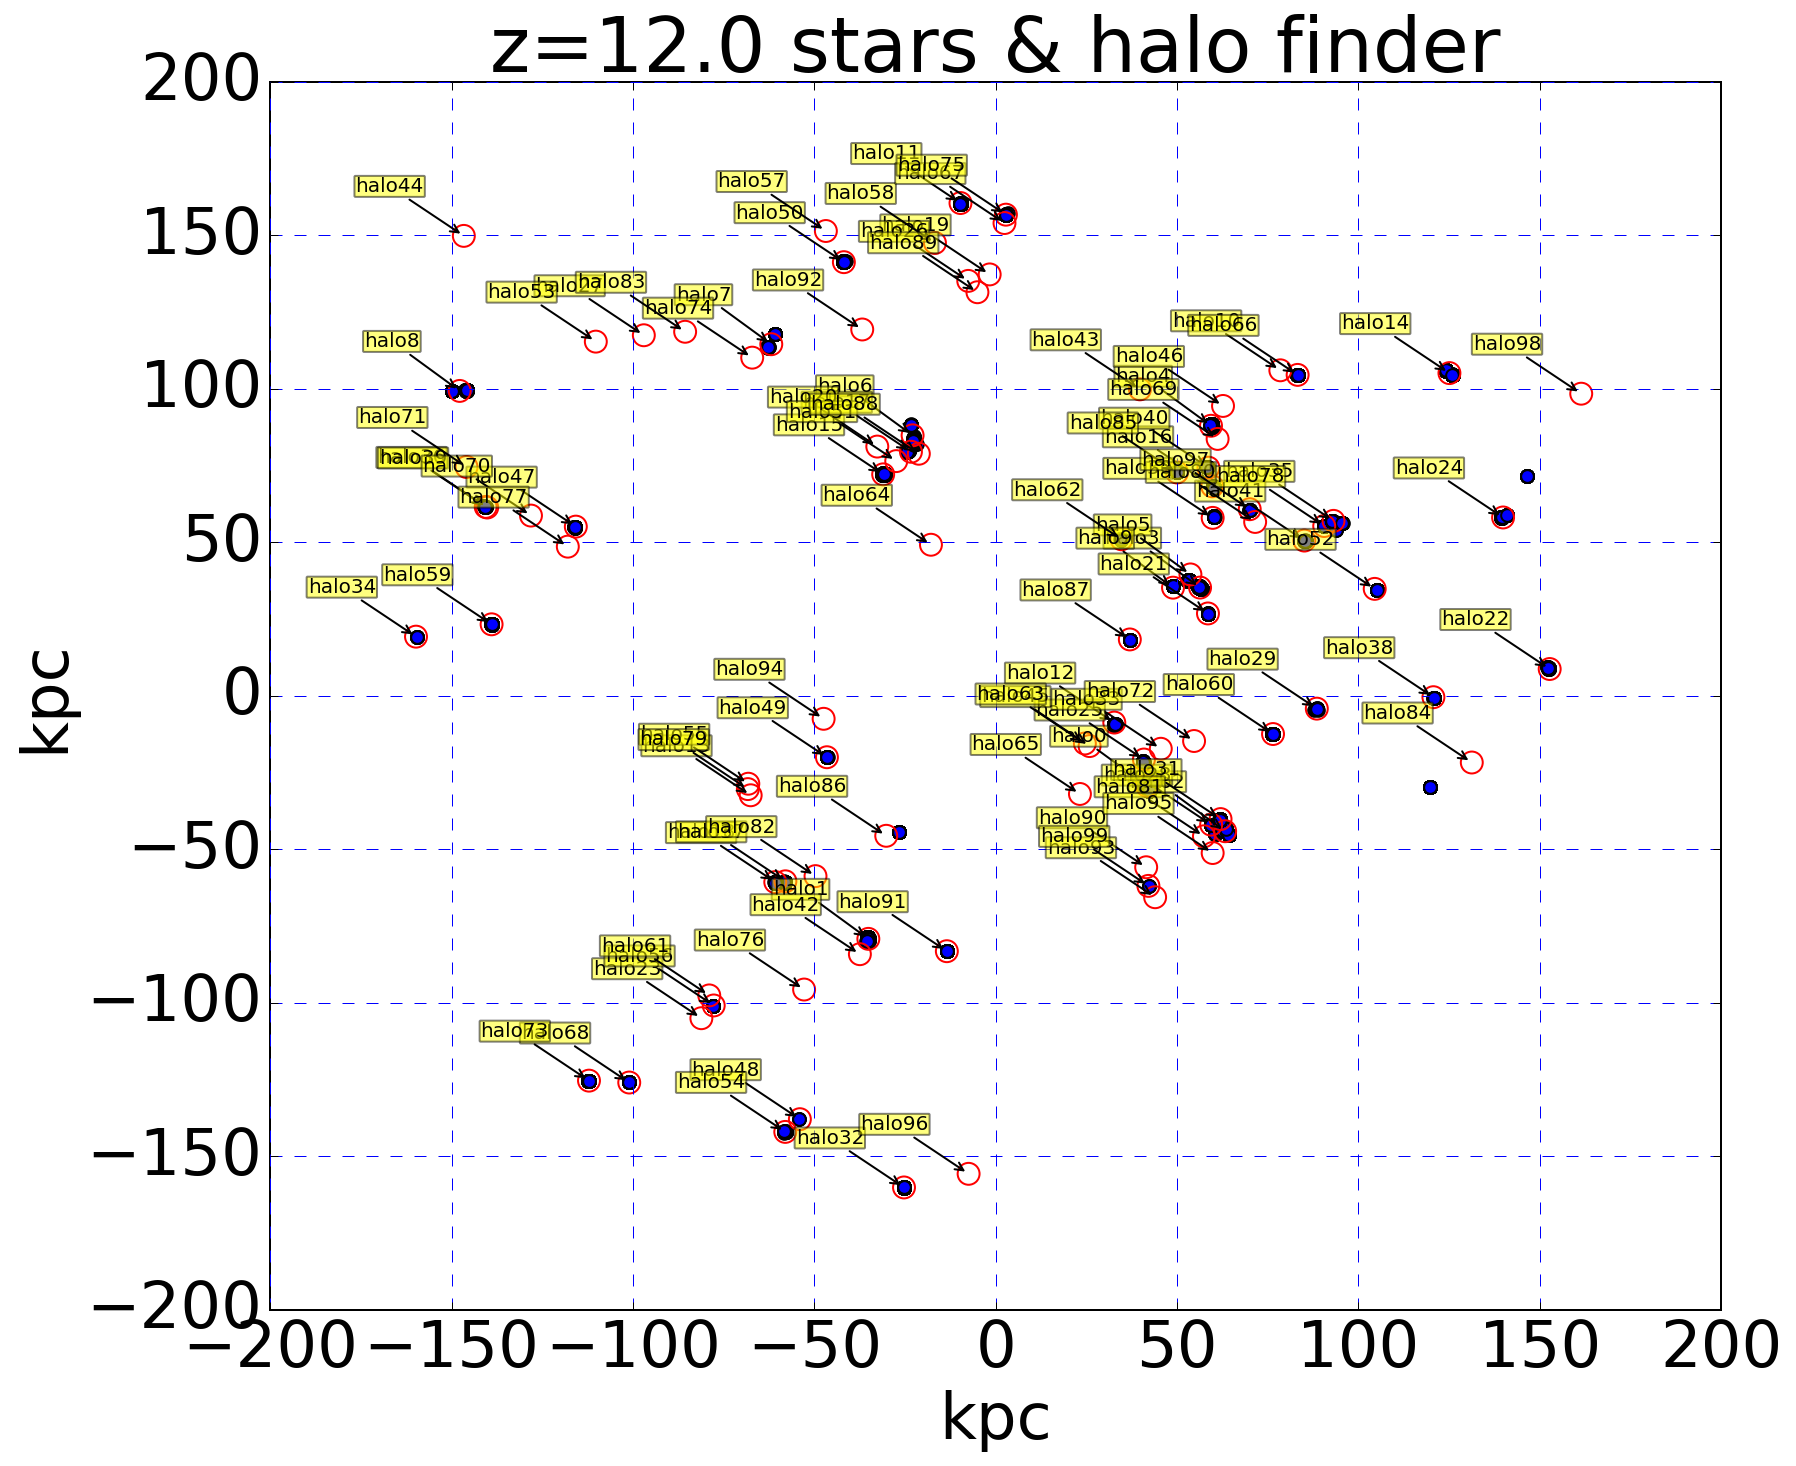

In [17]:
htp = 100
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0],halosPos[:htp,1],s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc')
plt.ylabel('kpc')
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0],halosPos[:htp,1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()

7682

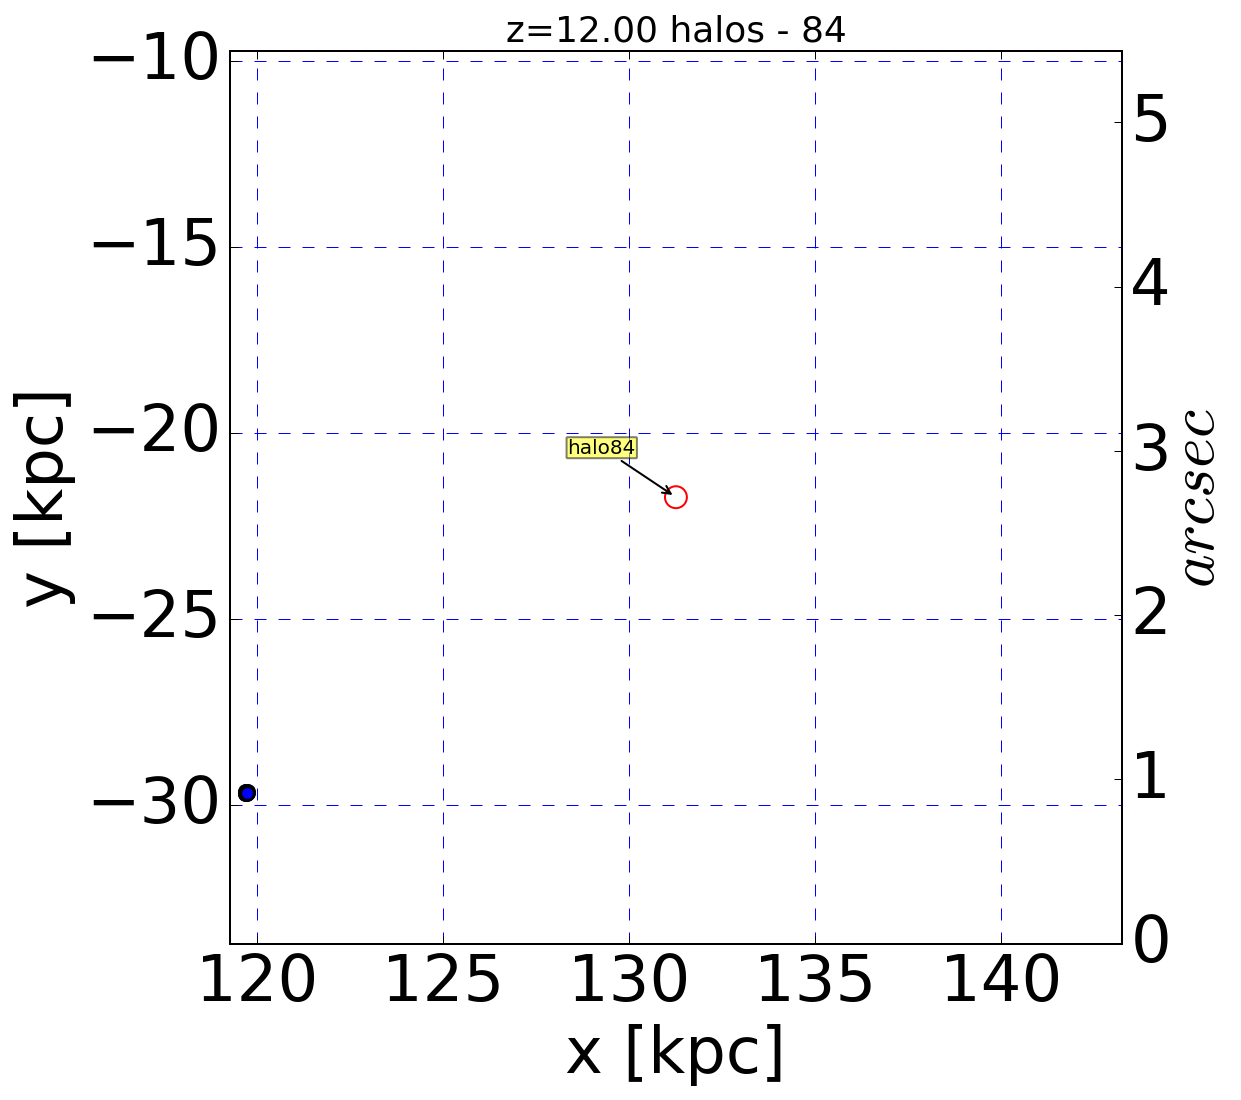

In [53]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = 25
for halo in range(84,85):
    ax=halos.pltView(locs,halosPos,halo,z,size)
    hax2 = ax.twinx()
    hax2.set_ylim([0,size/kpcPerArcSec])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
gc.collect()

In [17]:
size,arcPerKpc

(18.372715771737642, <Quantity 0.21771413925387748 arcsec / kpc>)

18.372715771737642 kpc = 4.0 arcsec
Num 5489, Tot Mass 4066617.0773890093 solMass
Num 9389, Tot Mass 7116680.662008287 solMass
Num 3184, Tot Mass 2346481.8309987336 solMass
Num 4501, Tot Mass 3319096.735969313 solMass
Num 4268, Tot Mass 3253390.4074256276 solMass


37279

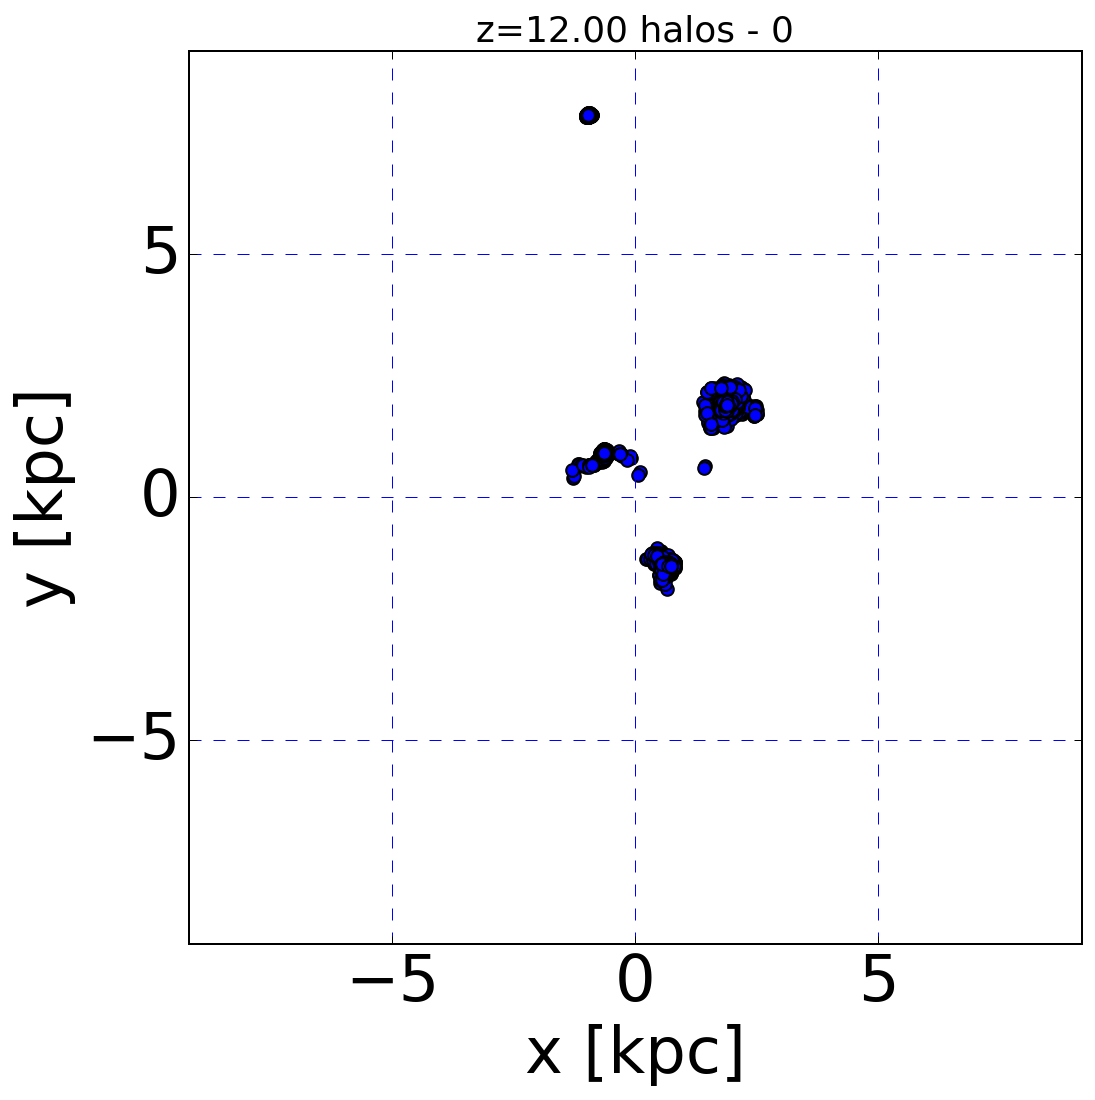

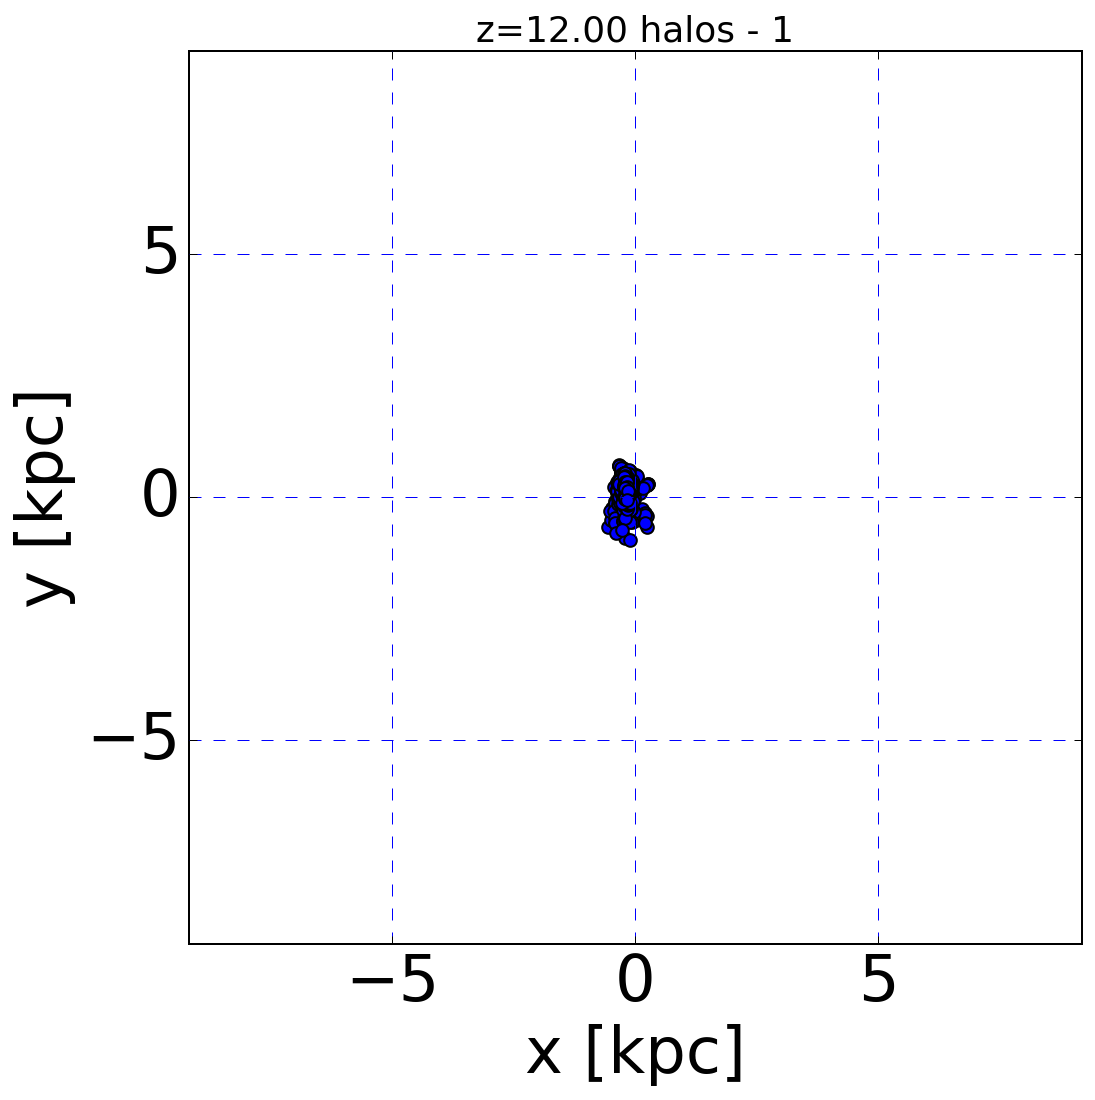

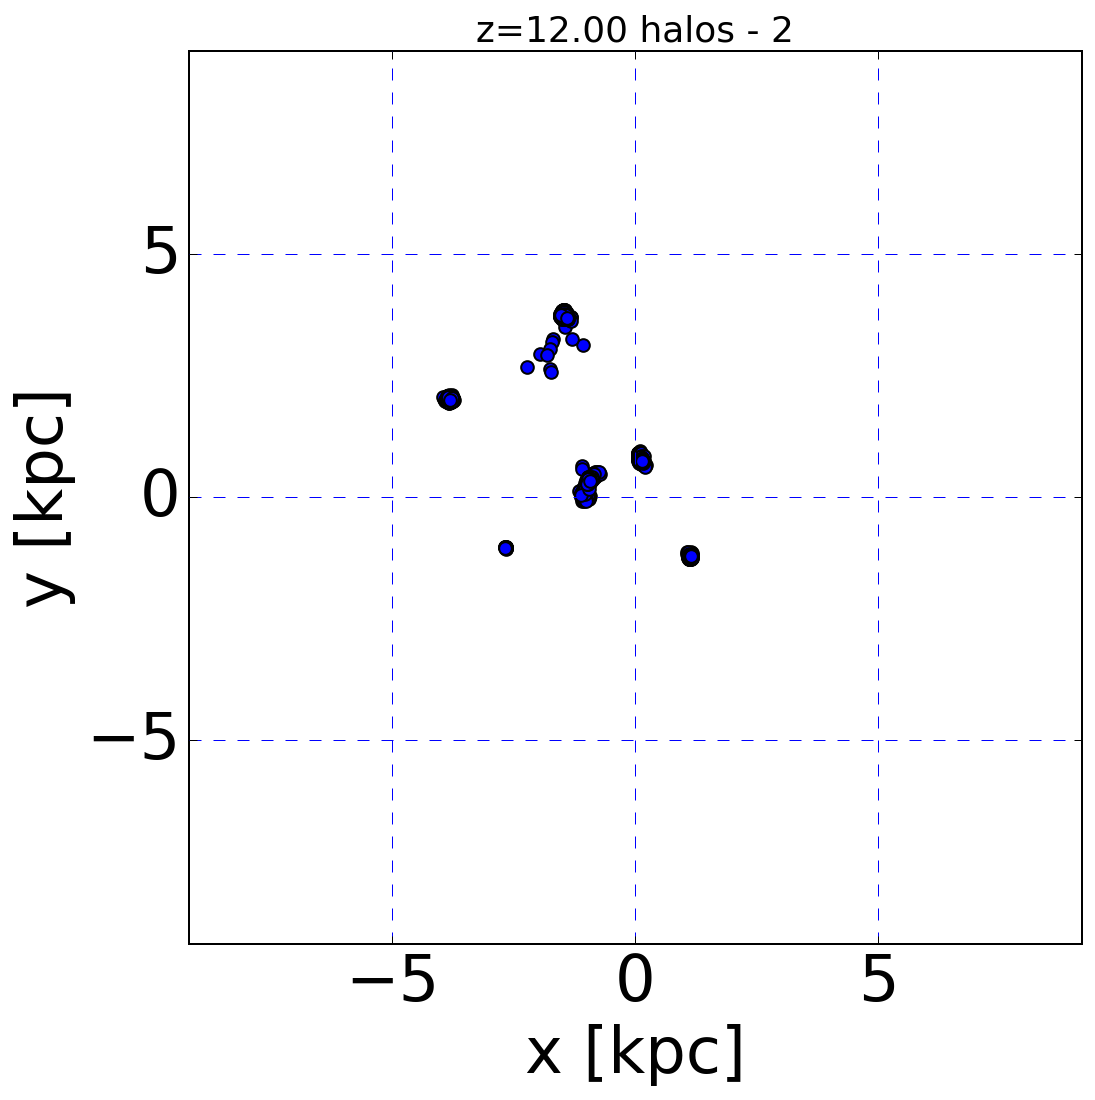

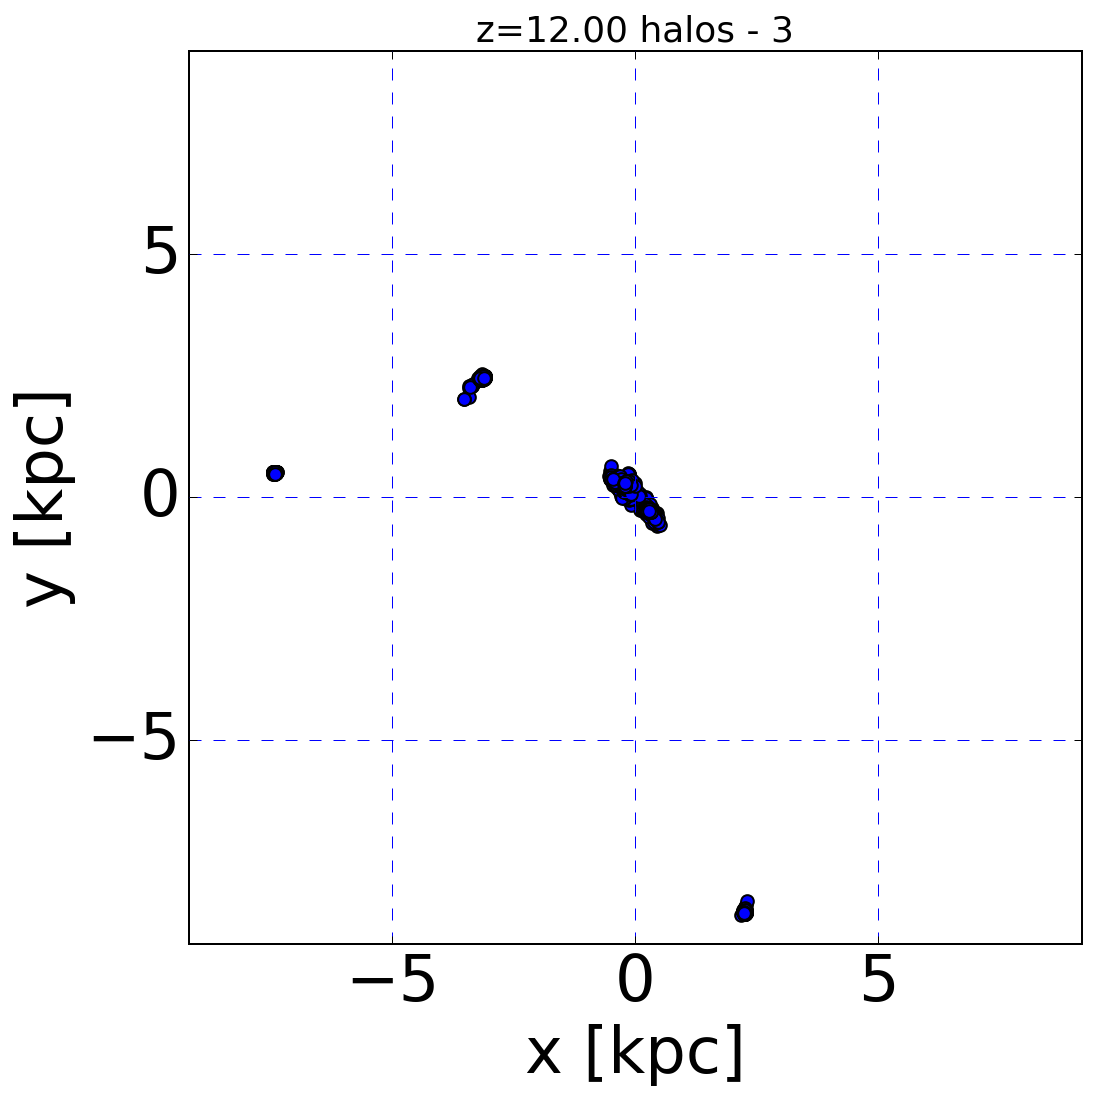

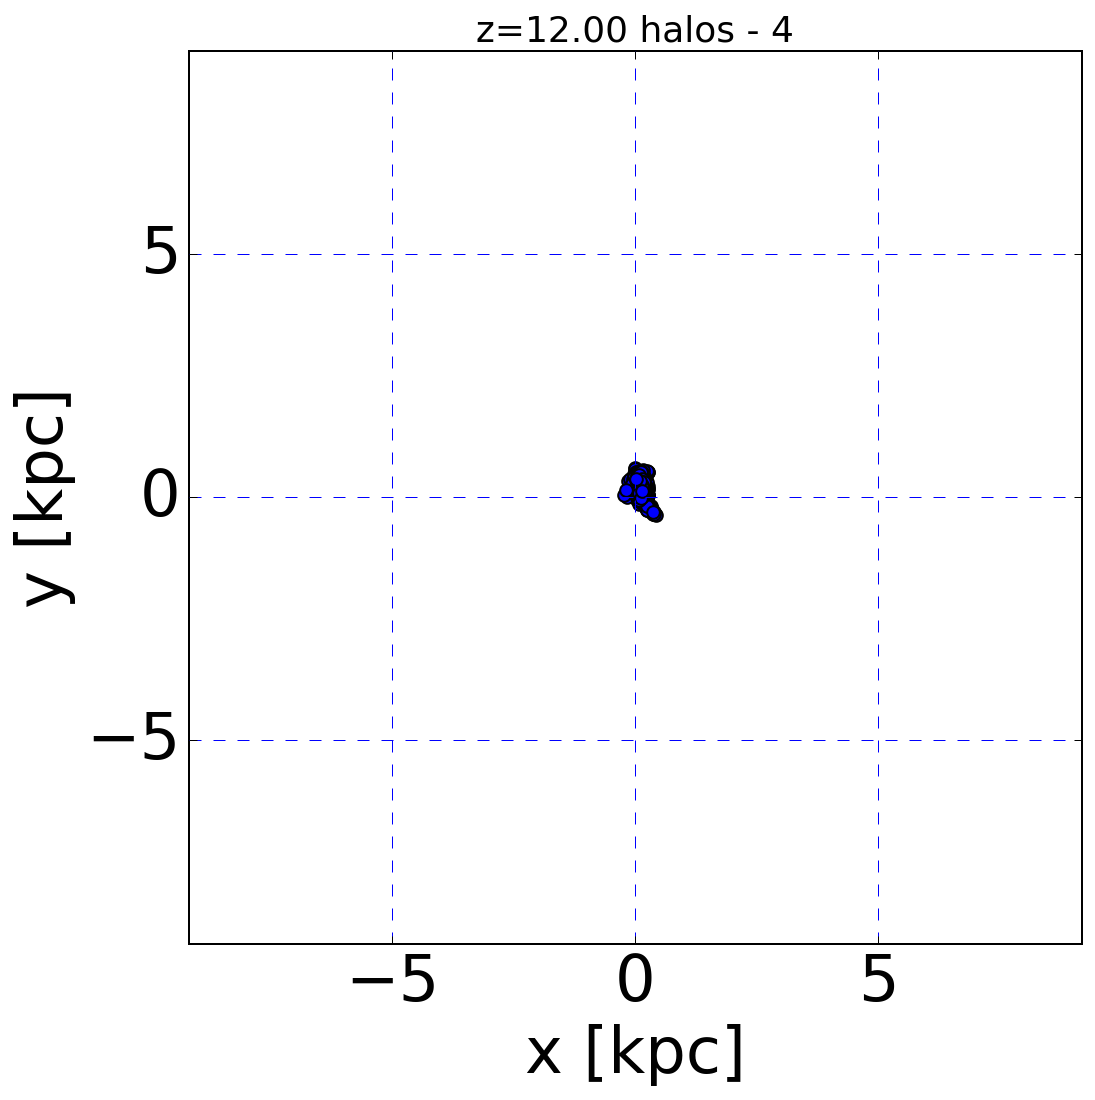

In [55]:
size = 4.0 * u.arcsec / arcPerKpc # Should use cosmology to find kpc for x arcsec... What should I use for x?
size = size.value
print("{} = {}".format(size * u.kpc,size * u.kpc* arcPerKpc))

for haloNum in range(0,5):
    # Load the stars for this halo
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getViewStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,haloNum,size)
    print("Num {}, Tot Mass {}".format(len(halospmass),halospmass.sum() * u.solMass))

    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    ax.scatter(halosplocs[:,0],halosplocs[:,1],s=40,c='b') # Plot star particles
    ax.grid(b=True, which='major', color='b', linestyle='--')
    ax.set_xlabel('x [kpc]')
    ax.set_ylabel('y [kpc]')
    ax.set_title('z=%.2lf halos - %d'%(z,haloNum),size=18)
    ax.set_xlim([-size/2,size/2])
    ax.set_ylim([-size/2,size/2])
    
gc.collect()

In [54]:
size = 25 # kpc
viewsplocs,viewspmass,viewspages,viewspZ,viewspPZ,viewspPPF = halos.getViewStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,84,size)
halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,84,size/2.0)


In [55]:
len(halospmass),np.sum(halospmass) * u.solMass

(0, <Quantity 0.0 solMass>)

In [56]:
len(viewspmass),np.sum(viewspmass) * u.solMass

(145, <Quantity 108193.73362653497 solMass>)

In [58]:
np.sqrt(25**2 * 3.0)

43.301270189221931

# Plot halo-specific histograms

Load the relevant data from min/max age & min/max Z @ redshift we are working
For array that map to lower Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at lower Z at exact age
For array that map to upper Z -- 
    Find lower bounding age
    Find upper bounding age
    Interpolate value at upper Z at exact age
Interpolate value at exact Z using exact age value at lower/uppper Z

In [83]:
from scipy.interpolate import interp1d

In [85]:
pop3Flux = np.genfromtxt('pop3TE_14.0.gz',dtype=float, delimiter=',', names=True)

In [86]:
pop3Flux['f210m'][pop3Flux['LogAge'] == 4.0]

array([ -2.75710000e-39])

In [ ]:
# How about an interpolating function for each file (2 files for upper/lower Z)
test = interp1d(pop3Flux['LogAge'],pop3Flux['f335m'])